In [1]:
import os
from os import path
import pandas as pd
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection as sk

In [2]:
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    new_var = this_array.copy()
    rat = (this_max - this_min)/(new_var.max() - new_var.min())
    new_var = new_var * rat
    new_var -= new_var.min()
    new_var += this_min
    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [3]:
#train = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/train.csv')
#train = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/machine_ratings/machine_mal_ratings.csv')
train = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/Agreement_Binary_Rating.csv')
len(train)

1332

In [4]:
display(train)

,InstanceID,RadiologistID,noduleID,imageZposition,Area,ConvexArea,Malignancy_1,Malignancy_2,Malignancy_3,Malignancy_4,Malignancy,Binary Rating,Binary_Rating_name,Agreement,Agreement_name,Two_Agreement,Two_Agreement_name
0,4,1,1,-117.500000,1094,1286,5,5,5,4,5,1,Malignant,2,High Radiologist Agreement,1,Full_High
1,118,3,5,-169.000000,246,251,4,5,3,2,4,3,Unknown,0,No Radiologist Agreement,0,Low_No
2,134,4,3,-186.500000,931,1062,5,5,3,4,5,3,Unknown,1,Low Radiologist Agreement,0,Low_No
3,143,4,4,-171.500000,161,167,4,4,3,2,4,3,Unknown,1,Low Radiologist Agreement,0,Low_No
4,175,4,6,-230.000000,71,73,2,1,1,1,1,0,Benign,2,High Radiologist Agreement,1,Full_High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,40771,4,2655,-199.500000,73,75,0,2,3,2,2,3,Unknown,1,Low Radiologist Agreement,0,Low_No
1328,40780,1,2657,-188.000000,638,759,3,5,5,5,5,1,Malignant,2,High Radiologist Agreement,1,Full_High
1329,40794,2,2656,-153.000000,437,464,2,5,5,5,5,1,Malignant,2,High Radiologist Agreement,1,Full_High
1330,40801,2,2658,-228.000000,657,674,4,3,4,3,4,3,Unknown,1,Low Radiologist Agreement,0,Low_No


In [5]:
training_data = train.sample(frac=0.8)
testing_data = train.drop(training_data.index)

In [6]:
print("training_data:",len(training_data))
print("testing_data:",len(testing_data))

training_data: 1066
testing_data: 266


In [7]:
train_nodIds = np.array(training_data['noduleID'])
test_nodIds = np.array(testing_data['noduleID'])

In [8]:
# collect all images for training
image_folder = '/Users/amalalmansour/Desktop/images_1332'
train_images = []
val_images = []
test_images = []
train_noduleId = []
val_noduleId = []
test_noduleId = []
print(image_folder)

for dir1 in os.listdir(image_folder):
    print(dir1)
    if not dir1.startswith('.'):
        for file in os.listdir(os.path.join(image_folder, dir1)):
            #print(file)
            noduleID = file.split('.')[0]
            if not file.startswith('.'):
                noduleID = int(noduleID)
                if noduleID in train_nodIds:
                    train_noduleId.append(noduleID)
                    temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                    temp_image = getNormed(temp_image)
                    #enlarged_img = getSamePadding(temp_image)
                    train_images.append(temp_image)
            
                '''if noduleID in val_nodIds:
                    val_noduleId.append(noduleID)
                    temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                    temp_image = getNormed(temp_image)
                    val_images.append(temp_image)'''
            
        
                if noduleID in test_nodIds:
                    test_noduleId.append(noduleID)
                    temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                    temp_image = getNormed(temp_image)
                    test_images.append(temp_image)

/Users/amalalmansour/Desktop/images_1332
.DS_Store
Malignancy_2
Malignancy_5
Malignancy_4
Malignancy_3
Malignancy_1


In [9]:
print("train_images:",len(train_images))
#print("val_images:",len(val_images))
print("test_images:",len(test_images))

train_images: 1066
test_images: 266


In [10]:
tr_df = pd.DataFrame(train_noduleId,columns =['noduleID'])
print(tr_df)

      noduleID
0         1084
1         2412
2         2374
3          471
4         1907
...        ...
1061       643
1062      2609
1063       904
1064      2594
1065       290

[1066 rows x 1 columns]


In [11]:
train_slices = pd.merge(tr_df, training_data)
display(train_slices)

,noduleID,InstanceID,RadiologistID,imageZposition,Area,ConvexArea,Malignancy_1,Malignancy_2,Malignancy_3,Malignancy_4,Malignancy,Binary Rating,Binary_Rating_name,Agreement,Agreement_name,Two_Agreement,Two_Agreement_name
0,1084,15915,4,-215.000,82,88,2,3,0,2,2,3,Unknown,1,Low Radiologist Agreement,0,Low_No
1,2412,36785,4,-81.000,98,107,2,2,4,2,2,0,Benign,2,High Radiologist Agreement,1,Full_High
2,2374,36253,4,1575.500,120,126,2,1,3,2,2,3,Unknown,1,Low Radiologist Agreement,0,Low_No
3,471,6853,2,-218.000,147,149,2,3,4,2,2,3,Unknown,1,Low Radiologist Agreement,0,Low_No
4,1907,29039,3,-169.125,61,61,2,1,4,2,2,3,Unknown,1,Low Radiologist Agreement,0,Low_No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,643,9251,2,-85.500,46,46,1,1,1,1,1,0,Benign,3,Full Radiologists Agreement,1,Full_High
1062,2609,39936,3,-52.680,53,54,1,1,1,1,1,0,Benign,3,Full Radiologists Agreement,1,Full_High
1063,904,13301,4,-56.000,105,107,1,1,0,1,1,0,Benign,2,High Radiologist Agreement,1,Full_High
1064,2594,39806,1,-137.600,127,128,1,1,1,1,1,0,Benign,3,Full Radiologists Agreement,1,Full_High


In [12]:
te_df = pd.DataFrame(test_noduleId,columns =['noduleID'])
print(te_df)

     noduleID
0        1482
1         113
2        2039
3        1081
4        1959
..        ...
261      1067
262      1273
263      1101
264       657
265      2219

[266 rows x 1 columns]


In [13]:
test_slices = pd.merge(te_df, testing_data)
display(test_slices)

,noduleID,InstanceID,RadiologistID,imageZposition,Area,ConvexArea,Malignancy_1,Malignancy_2,Malignancy_3,Malignancy_4,Malignancy,Binary Rating,Binary_Rating_name,Agreement,Agreement_name,Two_Agreement,Two_Agreement_name
0,1482,22185,1,-184.395004,78,81,2,2,1,0,2,3,Unknown,1,Low Radiologist Agreement,0,Low_No
1,113,1483,3,-143.250000,82,85,2,3,4,2,2,3,Unknown,1,Low Radiologist Agreement,0,Low_No
2,2039,30642,3,1649.500000,143,145,2,2,3,2,2,0,Benign,2,High Radiologist Agreement,1,Full_High
3,1081,15881,2,-568.599976,74,76,2,2,3,1,2,3,Unknown,1,Low Radiologist Agreement,0,Low_No
4,1959,29610,3,-135.764999,44,46,0,2,2,2,2,0,Benign,2,High Radiologist Agreement,1,Full_High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,1067,15640,1,873.100000,80,82,3,1,0,1,1,3,Unknown,1,Low Radiologist Agreement,0,Low_No
262,1273,19109,3,-167.250000,143,144,1,1,1,1,1,0,Benign,3,Full Radiologists Agreement,1,Full_High
263,1101,16188,4,1464.500000,68,71,1,1,0,1,1,0,Benign,2,High Radiologist Agreement,1,Full_High
264,657,9498,4,-138.250000,116,117,2,1,3,1,1,3,Unknown,1,Low Radiologist Agreement,0,Low_No


In [14]:
x_train, x_val, y_train, y_val = sk.train_test_split(train_images,train_slices['Agreement'],test_size=0.2, shuffle=True)

In [15]:
x_test = test_images
y_test = test_slices['Agreement']

In [16]:
y_train.value_counts()

1    480
2    214
0     97
3     61
Name: Agreement, dtype: int64

In [17]:
y_test.value_counts()

1    148
2     64
0     32
3     22
Name: Agreement, dtype: int64

In [18]:
train_images = np.array(x_train)
print(len(train_images))
val_images = np.array(x_val)
print(len(val_images))
test_images = np.array(x_test)
print(len(test_images))

852
214
266


In [19]:
# Reshape the data so the pixel vectors turn into arrays, and so the instance id's are also arrays
train_data = train_images.reshape(train_images.shape[0],71,71,1)  
train_ids = np.array(y_train)
val_data = val_images.reshape(val_images.shape[0],71,71,1)  
val_ids = np.array(y_val)
test_data = test_images.reshape(test_images.shape[0], 71, 71,1)
test_ids = np.array(y_test)

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(71, 71, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [21]:
#model.summary()

In [22]:
model.add(layers.Flatten())
model.output_shape

(None, 65536)

In [23]:
#model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4,activation='softmax'))
#model.add(layers.Dense(2,activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 4)                 262148    
                                                                 
Total params: 280,964
Trainable params: 280,964
Non-trainable params: 0
__________________________________________________

In [25]:
# Compile the model
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_data, train_ids, epochs=50
                    , validation_data=(val_data, val_ids))

Epoch 1/50
27/27 [==============================] - 1s 22ms/step - loss: 30.1126 - accuracy: 0.4460 - val_loss: 1.2447 - val_accuracy: 0.5280
Epoch 2/50
27/27 [==============================] - 0s 14ms/step - loss: 1.1427 - accuracy: 0.5728 - val_loss: 1.1530 - val_accuracy: 0.5280
Epoch 3/50
27/27 [==============================] - 0s 14ms/step - loss: 0.8806 - accuracy: 0.6373 - val_loss: 1.2197 - val_accuracy: 0.4953
Epoch 4/50
27/27 [==============================] - 0s 14ms/step - loss: 0.5947 - accuracy: 0.7840 - val_loss: 1.3806 - val_accuracy: 0.4953
Epoch 5/50
27/27 [==============================] - 0s 14ms/step - loss: 0.3238 - accuracy: 0.8873 - val_loss: 2.0509 - val_accuracy: 0.4907
Epoch 6/50
27/27 [==============================] - 0s 12ms/step - loss: 0.1741 - accuracy: 0.9507 - val_loss: 2.0441 - val_accuracy: 0.4579
Epoch 7/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0750 - accuracy: 0.9824 - val_loss: 2.4586 - val_accuracy: 0.4626
Epoch 8/50
2

In [26]:
#model.save("/Users/amalalmansour/Desktop/New_Images/Malignancy/CNN/CNN_model_All")

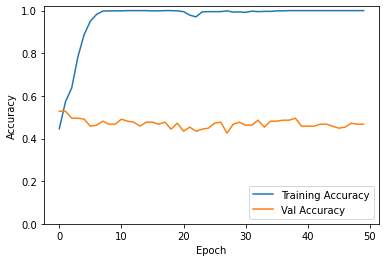

In [27]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.02])
plt.legend(loc='lower right')

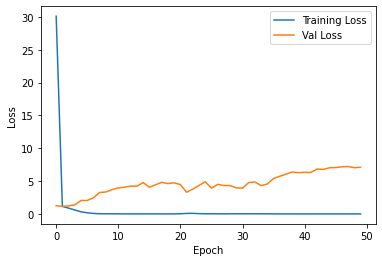

In [28]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.0, 1.02])
plt.legend(loc='upper right')

In [29]:
test_loss, test_acc = model.evaluate(test_data,  test_ids, verbose=2)

9/9 - 0s - loss: 8.5564 - accuracy: 0.4586 - 83ms/epoch - 9ms/step


In [30]:
test_acc

0.45864662528038025

In [31]:
predictions = model.predict(test_data)

In [32]:
#y_pred = (predictions > 0.5)

In [33]:
print(predictions)

[[2.8531165e-03 5.6794921e-05 9.4891095e-01 4.8179179e-02]
 [8.0587726e-16 1.0000000e+00 1.2602007e-16 5.8861365e-20]
 [2.9643843e-11 1.0000000e+00 1.5533492e-09 3.6510842e-12]
 ...
 [4.8577256e-08 8.0736548e-02 9.1424978e-01 5.0137285e-03]
 [6.1184391e-13 9.9998808e-01 1.1956946e-05 2.8172329e-17]
 [1.4451255e-10 3.5781737e-05 5.1580498e-04 9.9944848e-01]]


In [34]:
y_preds_multiclass = predictions.argmax(axis=1)

In [35]:
y_preds_multiclass

array([2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2,
       2, 1, 2, 1, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1,
       2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0,
       1, 2, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1,
       3, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 1, 2, 0, 1, 3, 2, 1, 2, 2, 1,
       2, 1, 2, 0, 2, 2, 1, 1, 2, 3, 2, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2, 2,
       1, 3])

In [36]:
tr_predictions = model.predict(train_data)
y_tr_preds_multiclass = tr_predictions.argmax(axis=1)

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
import itertools
#creating cunfusion matrix

def custom_confusion_matrix(y_true, y_pred, classes=None,figsize=(15,15), text_size=15):
    #figsize = (10,10)
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]#normalize the confusion matrix
    n_classes = cm.shape[0]
    
    #adjusting the cunfusion matrix
    fig, ax = plt.subplots(figsize=figsize)
    #Creating a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    #create classes
    #classes = False
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    #Label the axes
    ax.set(title="Confusion Matrix",
          xlabel="Predicted Label",
          ylabel="True Label",
          xticks=np.arange(n_classes),
          yticks=np.arange(n_classes),
          xticklabels=labels,
          yticklabels=labels)
    #Set axis label to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    #Adjust label size
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size)
    #Set threshold for diffferent colors
    threshold = (cm.max() + cm.min())/2.
    
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,f"{cm[i,j]}({cm_norm[i,j]*100: .1f}%)",
                horizontalalignment="center",
                color="white" if cm[i,j]>threshold else "black",
                size = text_size)

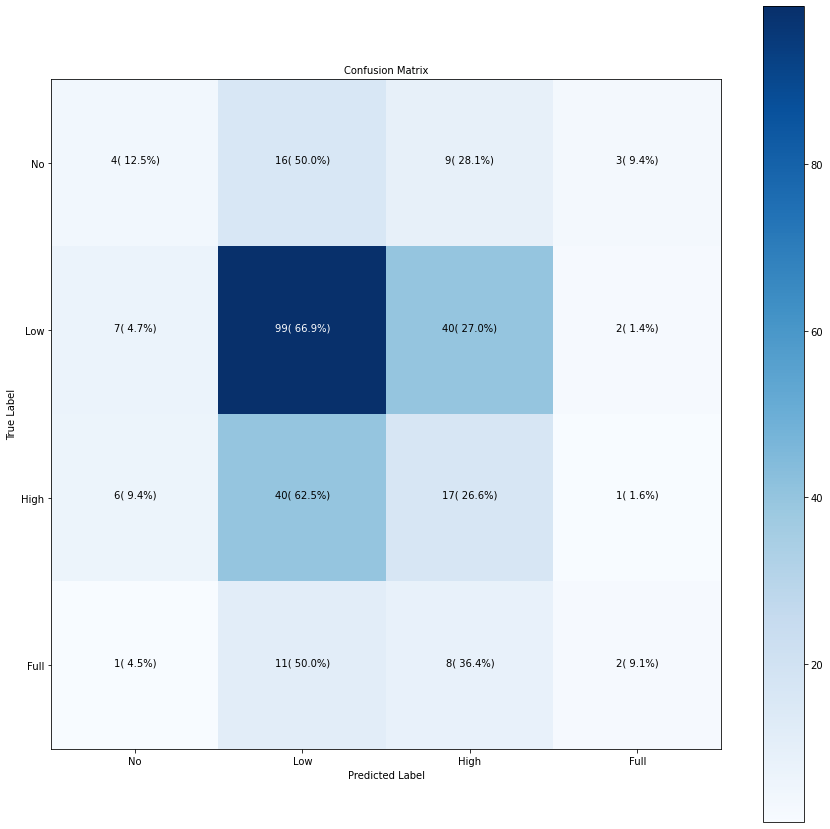

In [39]:
classes_name = ["No","Low", "High", "Full"]
custom_confusion_matrix(test_ids,
                       y_preds_multiclass,
                       classes_name,
                       (15,15),
                       10)

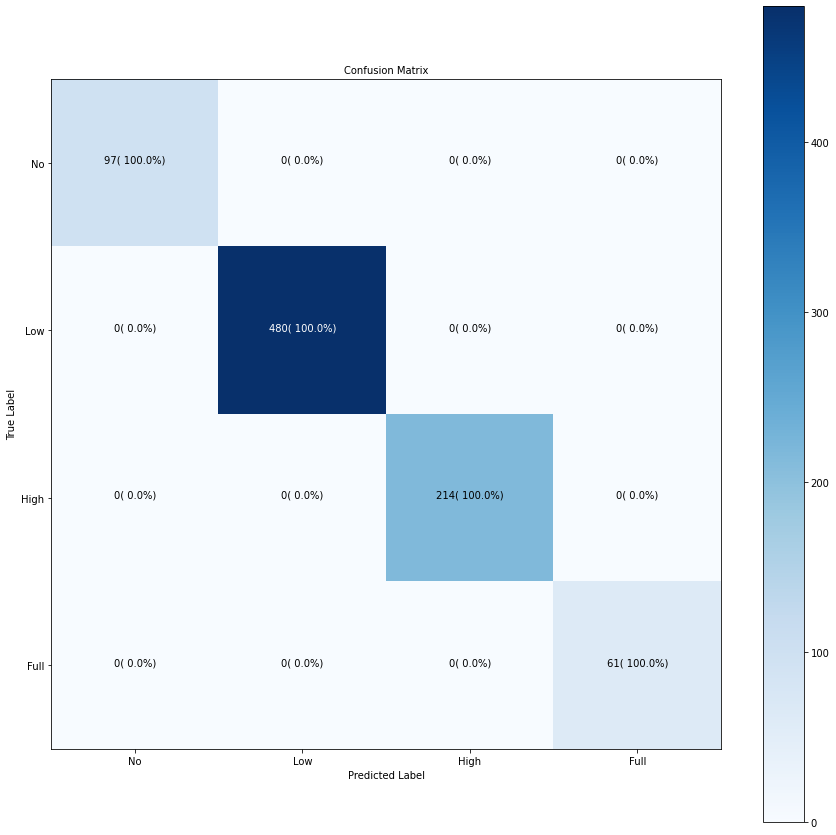

In [40]:
custom_confusion_matrix(train_ids,
                       y_tr_preds_multiclass,
                       classes_name,
                       (15,15),
                       10)